# Appendix

## torch cat vs stack

In [ ]:
from torch.nn.functional import conv2d
import torch

In [157]:
a = torch.Tensor([1])
b = torch.Tensor([2])
c = torch.cat([a,b], dim=0)
print(c)

tensor([1., 2.])


In [ ]:
a = torch.Tensor([1])
b = torch.Tensor([2])
c = torch.cat([a,b], dim=0)
print(c)

In [158]:
a = torch.Tensor([1])
b = torch.Tensor([2])
c = torch.stack([a,b], dim=0)
d = torch.stack([a,b], dim=1)
print(c)
print(d)

tensor([[1.],
        [2.]])
tensor([[1., 2.]])


## Partial functions

In [166]:
from functools import partial
import matplotlib.pyplot as plt

In [167]:
def general_quadratic_function(x: np.array, params: tuple):
    a,b,c = params
    return a*(x**2) + (b*x) + c

In [168]:
our_quadratic_function = partial(general_quadratic_function, params=(1,2,3))

In [169]:
our_quadratic_function(np.arange(10))

array([  3,   6,  11,  18,  27,  38,  51,  66,  83, 102])

## Plot functions

In [270]:
np.arange(0,10,0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1,
       5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4,
       6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7,
       7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. ,
       9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])

In [271]:
def plot_function(func, x=np.arange(0,10,0.1), ax=None, **kwargs):
    if 'figsize' not in kwargs:
        kwargs['figsize'] = (3,3)
    if ax is None: 
        ax = plt.subplots(**kwargs)[1]
    
    y = func(x)
    ax.plot(x, y)

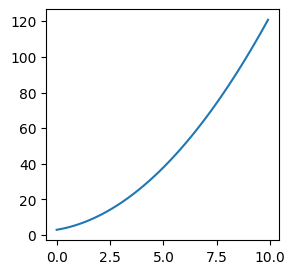

In [272]:
plot_function(our_quadratic_function)

## Convolutions

In [70]:
from torch.nn.functional import conv2d
import torch

### Conv2d

We explore [functional form](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html) of Conv2. Let's make some inputs and kernels:

In [71]:
torch.manual_seed(14)
x = torch.randn(16, 3, 16, 16) 
kernel = torch.randn(10, 3, 3, 3)

basic `Conv2` does what we expect:

In [72]:
y = conv2d(x, kernel)
print(x.shape)
print(y.shape)

torch.Size([16, 3, 16, 16])
torch.Size([16, 10, 14, 14])


Formula for output size for Convolutions is: $[(W−K+2P)/S]+1), where [] is the `np.floor`:

In [128]:
def get_output_size(w,k,p,s): 
    return int(((w-k+2*p)/s)+1)

In above example:

In [129]:
get_output_size(16, 3, 0, 1)

14

if we want the same size, we could pass `padding='same'`:

In [130]:
y = conv2d(x, kernel, padding='same')
print(x.shape)
print(y.shape)

torch.Size([16, 3, 16, 16])
torch.Size([16, 10, 16, 16])


This works ok for stride=1, but for stride >1 'same' doesn't make sense anymore in PyTorch (raises `RuntimeError: padding='same' is not supported for strided convolutions)`. In TensorFlow however 'same' assumes one needs $width/stride$ size, which in our case should be 8, instead we get expected 7:

In [131]:
y = conv2d(x, kernel, stride=2)
print(x.shape)
print(y.shape)

torch.Size([16, 3, 16, 16])
torch.Size([16, 10, 7, 7])


formula checks out:

In [132]:
get_output_size(16, 3, 0, 2)

7

So what's the padding that we need? We need to do some math:

o = output size  
w = width  
p = padding  
s = stride    
if we solve the equation for p: 
o = int((w-k+2*p)/s) + 1   
o - 1 = int((w-k+2*p)/s)  
and here we have a range:  
o - 1 = int((w-k+2*p_min)/s) 
o - 1 = int((w-k+2*p_max)/s) 
solving this:
(o - 1) * s = min = w-k+2*p_min <= w-k+2*p <= w-k+2*p_max = max < o * s  
Note that inequality is not symmetric, the top bound is exclusive.
Then:  
p_min = ((o-1)*s - w + k) / 2   
p_max = (o*s - w + k) / 2  
which can both be decimal.
at this point we can just get the ceil of p_min and be happy: 
**$p = np.ceil(((o-1)*s - w + k) / 2)$**

In [319]:
def get_lowest_padding(w,k,s):
    o = np.ceil(w/s)
    p = (np.ceil((k - (w - (o-1)*s)) / 2)).astype(int)
    return p

In [326]:
get_lowest_padding(90,15,10)

3

Let's plot padding for many image widths:

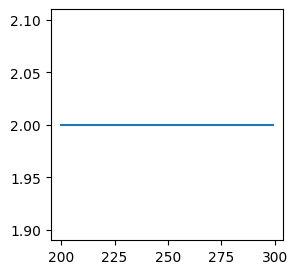

In [321]:
partial_get_padding = partial(get_lowest_padding, k=5, s=2)
x = np.arange(200, 300, 1)
plot_function(partial_get_padding, x)

In [322]:
np.unique(partial_get_padding(np.arange(200,300,1)))

array([2])

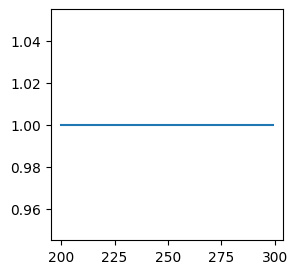

In [335]:
partial_get_padding = partial(get_lowest_padding, k=3, s=1)
x = np.arange(200, 300, 1)
plot_function(partial_get_padding, x)

So this is funny. Let's look into math again:

o = can be even or odd   
p = (np.ceil((k - (1 or 2)) / 2))   # generaly speaking p = (np.ceil((k - (1 to s) / 2))  
p = (np.ceil((5 - (1 or 2)) / 2))  
p = (np.ceil((4 or 3)/ 2))  
p = 2

so that's the reason.

We can also look into limits of p:

`o = np.ceil(w/s)`  
`p = (np.ceil(((o-1)*s - w + k) / 2))`  
note that p is maximized when `(o-1)*s - w` is highest, i.e. `w - (o-1)*s` is lowest, which is has lowest value of 1 (by definition of o it can't be 0):   
**np.ceil((k-s)/2) <= p <= np.ceil((k-1)/2)**

In [334]:
print(get_lowest_padding(90,16,10))  # np.ceil((k-s)/2) = (ceil((16-10)/2) = 3
print(get_lowest_padding(91,16,10))   # np.ceil((k-1)/2) = ceil(15/2) = 8 

3
8


Finally, for a special, but common case, w = s*o:

general equations:  
o = np.ceil(w/s)  
p = (np.ceil(((o-1)*s - w + k) / 2))  

then:  
p = (np.ceil((k-s) / 2))  

so padding doesn't depend on the width in this case. **We will stick with this formula since it makes it simple not to worry about the width, so long our images are divisible by s**. 

### Conv2Transpose

For transpose convolution (which upsample there is also `output_padding` that fills only one-side (useful for those 'same' paddings)



# UNet

In [ ]:
""" Full assembly of the parts to form the complete network """

from .unet_parts import *


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [ ]:
v